In [41]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error

Importer des données

In [42]:

data=pd.read_csv("./laboratory.csv")

In [43]:
data.head()

,TypPS,oxygen,pm10,cnt0_5,co,temperature,performance,co2,measuretime,so2,...,health,temperature_o2,cnt2_5,o3,humidity,dHdt,humidity_abs,sound,pm2_5,cnt0_3
0,14.966,20.688,0.007,4.867,1.522,20.867,910.0,548.505,1876,38.461,...,968.0,24.841,0.014,11.550,44.833,-0.03,8.182,21.999,0.0,16.234
1,14.996,20.687,0.001,3.496,1.521,20.865,915.0,543.500,1887,38.462,...,942.0,24.845,0.002,11.520,44.784,-0.06,8.172,24.962,0.0,14.324
2,15.000,20.687,0.000,5.134,1.521,20.866,916.0,542.134,1858,38.463,...,938.0,24.834,0.000,11.506,44.768,-0.07,8.170,25.293,0.0,15.826
3,14.081,20.688,0.213,4.223,1.521,20.864,918.0,539.314,1856,38.462,...,936.0,24.834,0.618,11.438,44.766,-0.04,8.169,26.403,0.0,12.719
4,14.258,20.687,0.152,8.701,1.522,20.867,915.0,543.551,1862,38.462,...,935.0,24.838,0.543,11.393,44.768,0.00,8.170,25.934,0.0,26.107


In [44]:
data.tail()

,TypPS,oxygen,pm10,cnt0_5,co,temperature,performance,co2,measuretime,so2,...,health,temperature_o2,cnt2_5,o3,humidity,dHdt,humidity_abs,sound,pm2_5,cnt0_3
51181,2.257,20.906,4.770,227.998,1.530,24.533,798.0,517.499,2046,176.872,...,820.0,28.700,0.958,28.679,39.472,-0.18,8.888,66.425,4.150,710.289
51182,1.920,20.906,4.169,229.625,1.529,24.546,782.0,524.201,2088,177.372,...,844.0,28.721,0.405,28.932,39.171,-0.30,8.826,65.066,3.800,725.006
51183,1.688,20.907,5.038,228.146,1.529,24.572,772.0,516.942,1827,173.799,...,803.0,28.757,0.529,29.264,38.641,-0.56,8.720,62.035,4.670,721.098
51184,1.515,20.905,5.092,246.341,1.530,24.590,761.0,517.797,1828,167.632,...,790.0,28.797,0.394,29.504,38.329,-0.63,8.658,65.898,4.789,780.604
51185,1.225,20.907,4.216,229.139,1.532,24.614,758.0,512.732,1999,162.133,...,822.0,28.815,0.840,29.658,38.106,-0.60,8.619,64.354,4.177,726.724


Les données sont de 12445x31 et nous devons filtrer les valeurs nulles et les paramètres de mesure qui ne nous concernent pas.

In [45]:
print(data)

        TypPS  oxygen   pm10   cnt0_5     co  temperature  performance  \
0      14.966  20.688  0.007    4.867  1.522       20.867        910.0   
1      14.996  20.687  0.001    3.496  1.521       20.865        915.0   
2      15.000  20.687  0.000    5.134  1.521       20.866        916.0   
3      14.081  20.688  0.213    4.223  1.521       20.864        918.0   
4      14.258  20.687  0.152    8.701  1.522       20.867        915.0   
...       ...     ...    ...      ...    ...          ...          ...   
51181   2.257  20.906  4.770  227.998  1.530       24.533        798.0   
51182   1.920  20.906  4.169  229.625  1.529       24.546        782.0   
51183   1.688  20.907  5.038  228.146  1.529       24.572        772.0   
51184   1.515  20.905  5.092  246.341  1.530       24.590        761.0   
51185   1.225  20.907  4.216  229.139  1.532       24.614        758.0   

           co2  measuretime      so2  ...  health  temperature_o2 cnt2_5  \
0      548.505         1876   38.46

**Nettoyage des données**

Supprimer les lignes nulles et les colonnes de caractéristiques inintéressantes

In [46]:
data.drop(['TypPS', 'cnt0_5','cnt1','performance','measuretime','temperature_o2','sound_max','cnt5','cnt10','dCO2dt','health','cnt2_5','o3','humidity_abs','dHdt','sound','cnt0_3'], axis=1, inplace=True)
data.dropna(inplace=True)
data['timestamp'] = pd.to_datetime(data['timestamp'])
dates_to_remove = ['2023-04-17', '2023-05-21']
dates_to_remove = pd.to_datetime(dates_to_remove)
data = data[~data['timestamp'].dt.normalize().isin(dates_to_remove)]
# data = data[(data != 0).all(axis=1)]
print(data)

       oxygen   pm10     co  temperature      co2      so2     no2  \
0      20.688  0.007  1.522       20.867  548.505   38.461  27.406   
1      20.687  0.001  1.521       20.865  543.500   38.462  27.771   
2      20.687  0.000  1.521       20.866  542.134   38.463  27.913   
3      20.688  0.213  1.521       20.864  539.314   38.462  28.165   
4      20.687  0.152  1.522       20.867  543.551   38.462  28.421   
...       ...    ...    ...          ...      ...      ...     ...   
51181  20.906  4.770  1.530       24.533  517.499  176.872  27.301   
51182  20.906  4.169  1.529       24.546  524.201  177.372  26.331   
51183  20.907  5.038  1.529       24.572  516.942  173.799  24.875   
51184  20.905  5.092  1.530       24.590  517.797  167.632  23.244   
51185  20.907  4.216  1.532       24.614  512.732  162.133  22.675   

                timestamp    pm1  dewpt     tvoc  pressure  humidity  pm2_5  
0     2023-03-22 17:42:49  0.000  8.114    0.000   983.066    44.833  0.000  
1  

Modifier le nom de timestamp et le convertir en index

In [47]:
data['timestamp'] = pd.to_datetime(data['timestamp'])

timestamp_col = data.pop('timestamp')
data.insert(0, 'date', timestamp_col)

data = data.set_index(['date'])

print(data.head())

                     oxygen   pm10     co  temperature      co2     so2  \
date                                                                      
2023-03-22 17:42:49  20.688  0.007  1.522       20.867  548.505  38.461   
2023-03-22 17:44:48  20.687  0.001  1.521       20.865  543.500  38.462   
2023-03-22 17:46:50  20.687  0.000  1.521       20.866  542.134  38.463   
2023-03-22 17:48:48  20.688  0.213  1.521       20.864  539.314  38.462   
2023-03-22 17:50:49  20.687  0.152  1.522       20.867  543.551  38.462   

                        no2  pm1  dewpt  tvoc  pressure  humidity  pm2_5  
date                                                                      
2023-03-22 17:42:49  27.406  0.0  8.114   0.0   983.066    44.833    0.0  
2023-03-22 17:44:48  27.771  0.0  8.095   0.0   983.102    44.784    0.0  
2023-03-22 17:46:50  27.913  0.0  8.090   0.0   983.112    44.768    0.0  
2023-03-22 17:48:48  28.165  0.0  8.088   0.0   983.112    44.766    0.0  
2023-03-22 17:50:49  28.

Présenter l'évolution de la valeur de la mesure qui nous intéresse au cours de l'échantillon

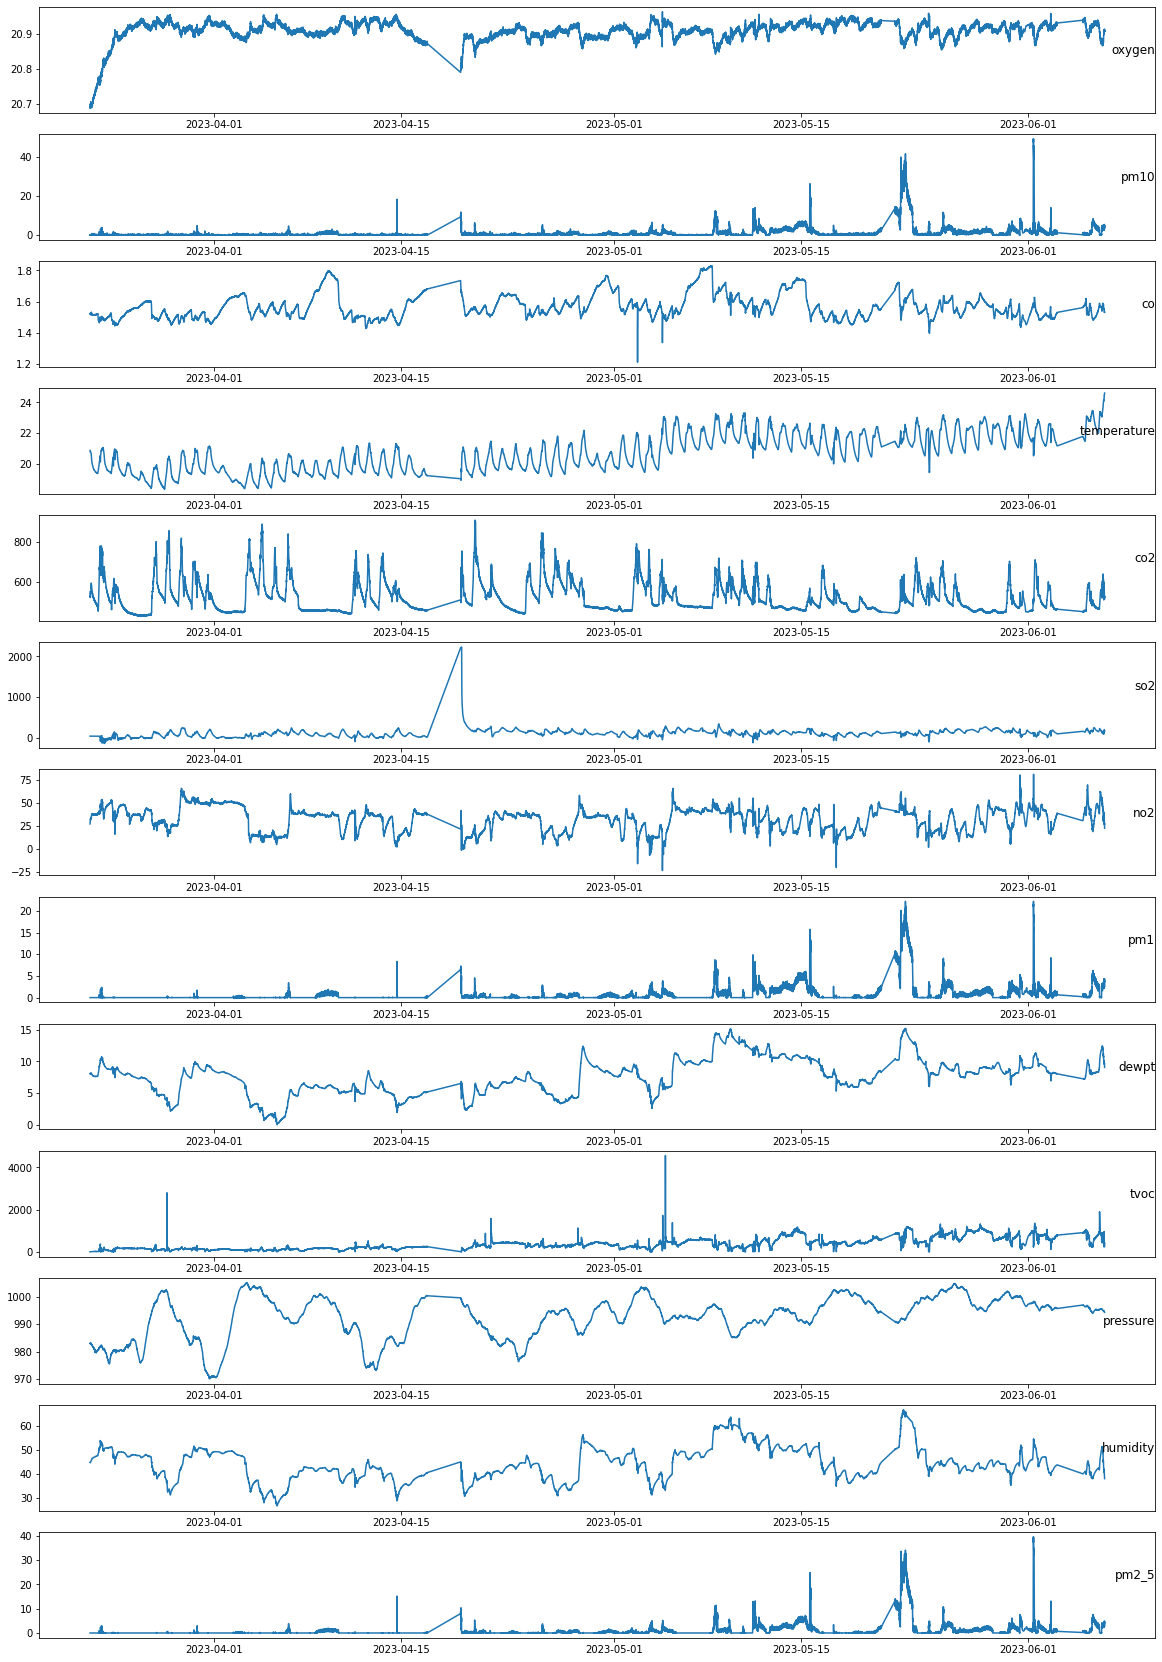

In [48]:
values = data.values
dates = data.index
groups = [0, 1, 2, 3, 4, 5, 6, 7 ,8 ,9 ,10 ,11 ,12]
i = 1

plt.figure(figsize=(20,30))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(dates,values[:, group])
    plt.title(data.columns[group], y=0.5, loc='right')
    i += 1
plt.show()#date

In [49]:
data

,oxygen,pm10,co,temperature,co2,so2,no2,pm1,dewpt,tvoc,pressure,humidity,pm2_5
date,,,,,,,,,,,,,
2023-03-22 17:42:49,20.688,0.007,1.522,20.867,548.505,38.461,27.406,0.000,8.114,0.000,983.066,44.833,0.000
2023-03-22 17:44:48,20.687,0.001,1.521,20.865,543.500,38.462,27.771,0.000,8.095,0.000,983.102,44.784,0.000
2023-03-22 17:46:50,20.687,0.000,1.521,20.866,542.134,38.463,27.913,0.000,8.090,0.000,983.112,44.768,0.000
2023-03-22 17:48:48,20.688,0.213,1.521,20.864,539.314,38.462,28.165,0.000,8.088,0.000,983.112,44.766,0.000
2023-03-22 17:50:49,20.687,0.152,1.522,20.867,543.551,38.462,28.421,0.000,8.091,0.000,983.097,44.768,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-06 16:52:03,20.906,4.770,1.530,24.533,517.499,176.872,27.301,3.683,9.514,314.435,994.396,39.472,4.150
2023-06-06 16:53:57,20.906,4.169,1.529,24.546,524.201,177.372,26.331,3.232,9.412,285.701,994.381,39.171,3.800
2023-06-06 16:56:11,20.907,5.038,1.529,24.572,516.942,173.799,24.875,4.050,9.232,244.609,994.372,38.641,4.670


**Multivariate LSTM Predictive Modeling**

In [50]:
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from keras.regularizers import l1, l2
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

Les données de la série temporelle sont converties en données d'apprentissage supervisé et des étiquettes sont générées. Les variables d'entrée sont ensuite normalisées. Compte tenu des mesures de la pollution et des conditions météorologiques de l'heure précédente (t-1), nous posons le problème de l'apprentissage supervisé pour prédire la concentration de la pollution à l'heure actuelle (t).

In [51]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    #  (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)] 
    agg = pd.concat(cols, axis=1)
    agg.columns = names


    if dropnan:
        agg.dropna(inplace=True)

    return agg

In [52]:
values = data.values

values = values.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

reframed = series_to_supervised(scaled, 1, 1)
reframed.drop(reframed.columns[[-2,-3,-10]], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),...,var1(t),var2(t),var3(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t),var13(t)
1,0.003632,0.000143,0.504839,0.403439,0.255490,0.075925,0.484318,0.0,0.532229,0.0,...,0.000000,0.000020,0.503226,0.245141,0.075925,0.487801,0.0,0.530976,0.0,0.0
2,0.000000,0.000020,0.503226,0.403120,0.245141,0.075925,0.487801,0.0,0.530976,0.0,...,0.000000,0.000000,0.503226,0.242316,0.075926,0.489156,0.0,0.530646,0.0,0.0
3,0.000000,0.000000,0.503226,0.403280,0.242316,0.075926,0.489156,0.0,0.530646,0.0,...,0.003632,0.004342,0.503226,0.236485,0.075925,0.491561,0.0,0.530514,0.0,0.0
4,0.003632,0.004342,0.503226,0.402961,0.236485,0.075925,0.491561,0.0,0.530514,0.0,...,0.000000,0.003099,0.504839,0.245246,0.075925,0.494003,0.0,0.530712,0.0,0.0
5,0.000000,0.003099,0.504839,0.403439,0.245246,0.075925,0.494003,0.0,0.530712,0.0,...,0.014542,0.002120,0.504839,0.242031,0.075925,0.497037,0.0,0.530382,0.0,0.0


In [53]:
values = reframed.values
num_rows = data.shape[0]
train_samples = int(num_rows // 1.25)
train = reframed.iloc[:train_samples, :]
test = reframed.iloc[train_samples:, :]

train_X, train_y = train.iloc[:, :-10].values, train.iloc[:, -10:].values
test_X, test_y = test.iloc[:, :-10].values, test.iloc[:, -10:].values

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(39992, 1, 13) (39992, 10) (9997, 1, 13) (9997, 10)


Define the LSTM model

Il y a 50 neurones dans la première couche cachée et 10 neurones dans la couche de sortie pour prédire la concentration de pollution. La dimension des données d'entrée sera de 1 pas de temps (c'est-à-dire 2 secondes) et de 13 caractéristiques.

In [54]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.5))
model.add(Dense(10))
model.compile(loss='mae', optimizer='adam')
print(model.summary())
# model = Sequential()
# model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]), kernel_regularizer=l2(0.001)))
# model.add(Dropout(0.5))
# model.add(Dense(10))
# model.add(Dropout(0.5))
# model.compile(loss='mae', optimizer=Adam(learning_rate=0.001))
# print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 50)                12800     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                510       
Total params: 13,310
Trainable params: 13,310
Non-trainable params: 0
_________________________________________________________________
None


Training the LSTM model

Epoch 1/300
556/556 - 1s - loss: 0.0913 - val_loss: 0.0744
Epoch 2/300
556/556 - 1s - loss: 0.0567 - val_loss: 0.0639
Epoch 3/300
556/556 - 1s - loss: 0.0462 - val_loss: 0.0604
Epoch 4/300
556/556 - 1s - loss: 0.0407 - val_loss: 0.0562
Epoch 5/300
556/556 - 1s - loss: 0.0369 - val_loss: 0.0512
Epoch 6/300
556/556 - 1s - loss: 0.0340 - val_loss: 0.0485
Epoch 7/300
556/556 - 1s - loss: 0.0319 - val_loss: 0.0480
Epoch 8/300
556/556 - 1s - loss: 0.0302 - val_loss: 0.0472
Epoch 9/300
556/556 - 1s - loss: 0.0293 - val_loss: 0.0470
Epoch 10/300
556/556 - 1s - loss: 0.0289 - val_loss: 0.0488
Epoch 11/300
556/556 - 1s - loss: 0.0287 - val_loss: 0.0504
Epoch 12/300
556/556 - 1s - loss: 0.0284 - val_loss: 0.0497
Epoch 13/300
556/556 - 1s - loss: 0.0281 - val_loss: 0.0490
Epoch 14/300
556/556 - 1s - loss: 0.0279 - val_loss: 0.0489
Epoch 15/300
556/556 - 1s - loss: 0.0279 - val_loss: 0.0487
Epoch 16/300
556/556 - 1s - loss: 0.0275 - val_loss: 0.0479
Epoch 17/300
556/556 - 1s - loss: 0.0273 - val_lo

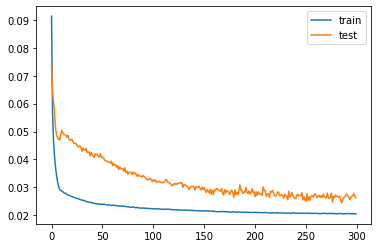

In [55]:
history = model.fit(train_X, train_y, epochs=300, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Evaluating LSTM models

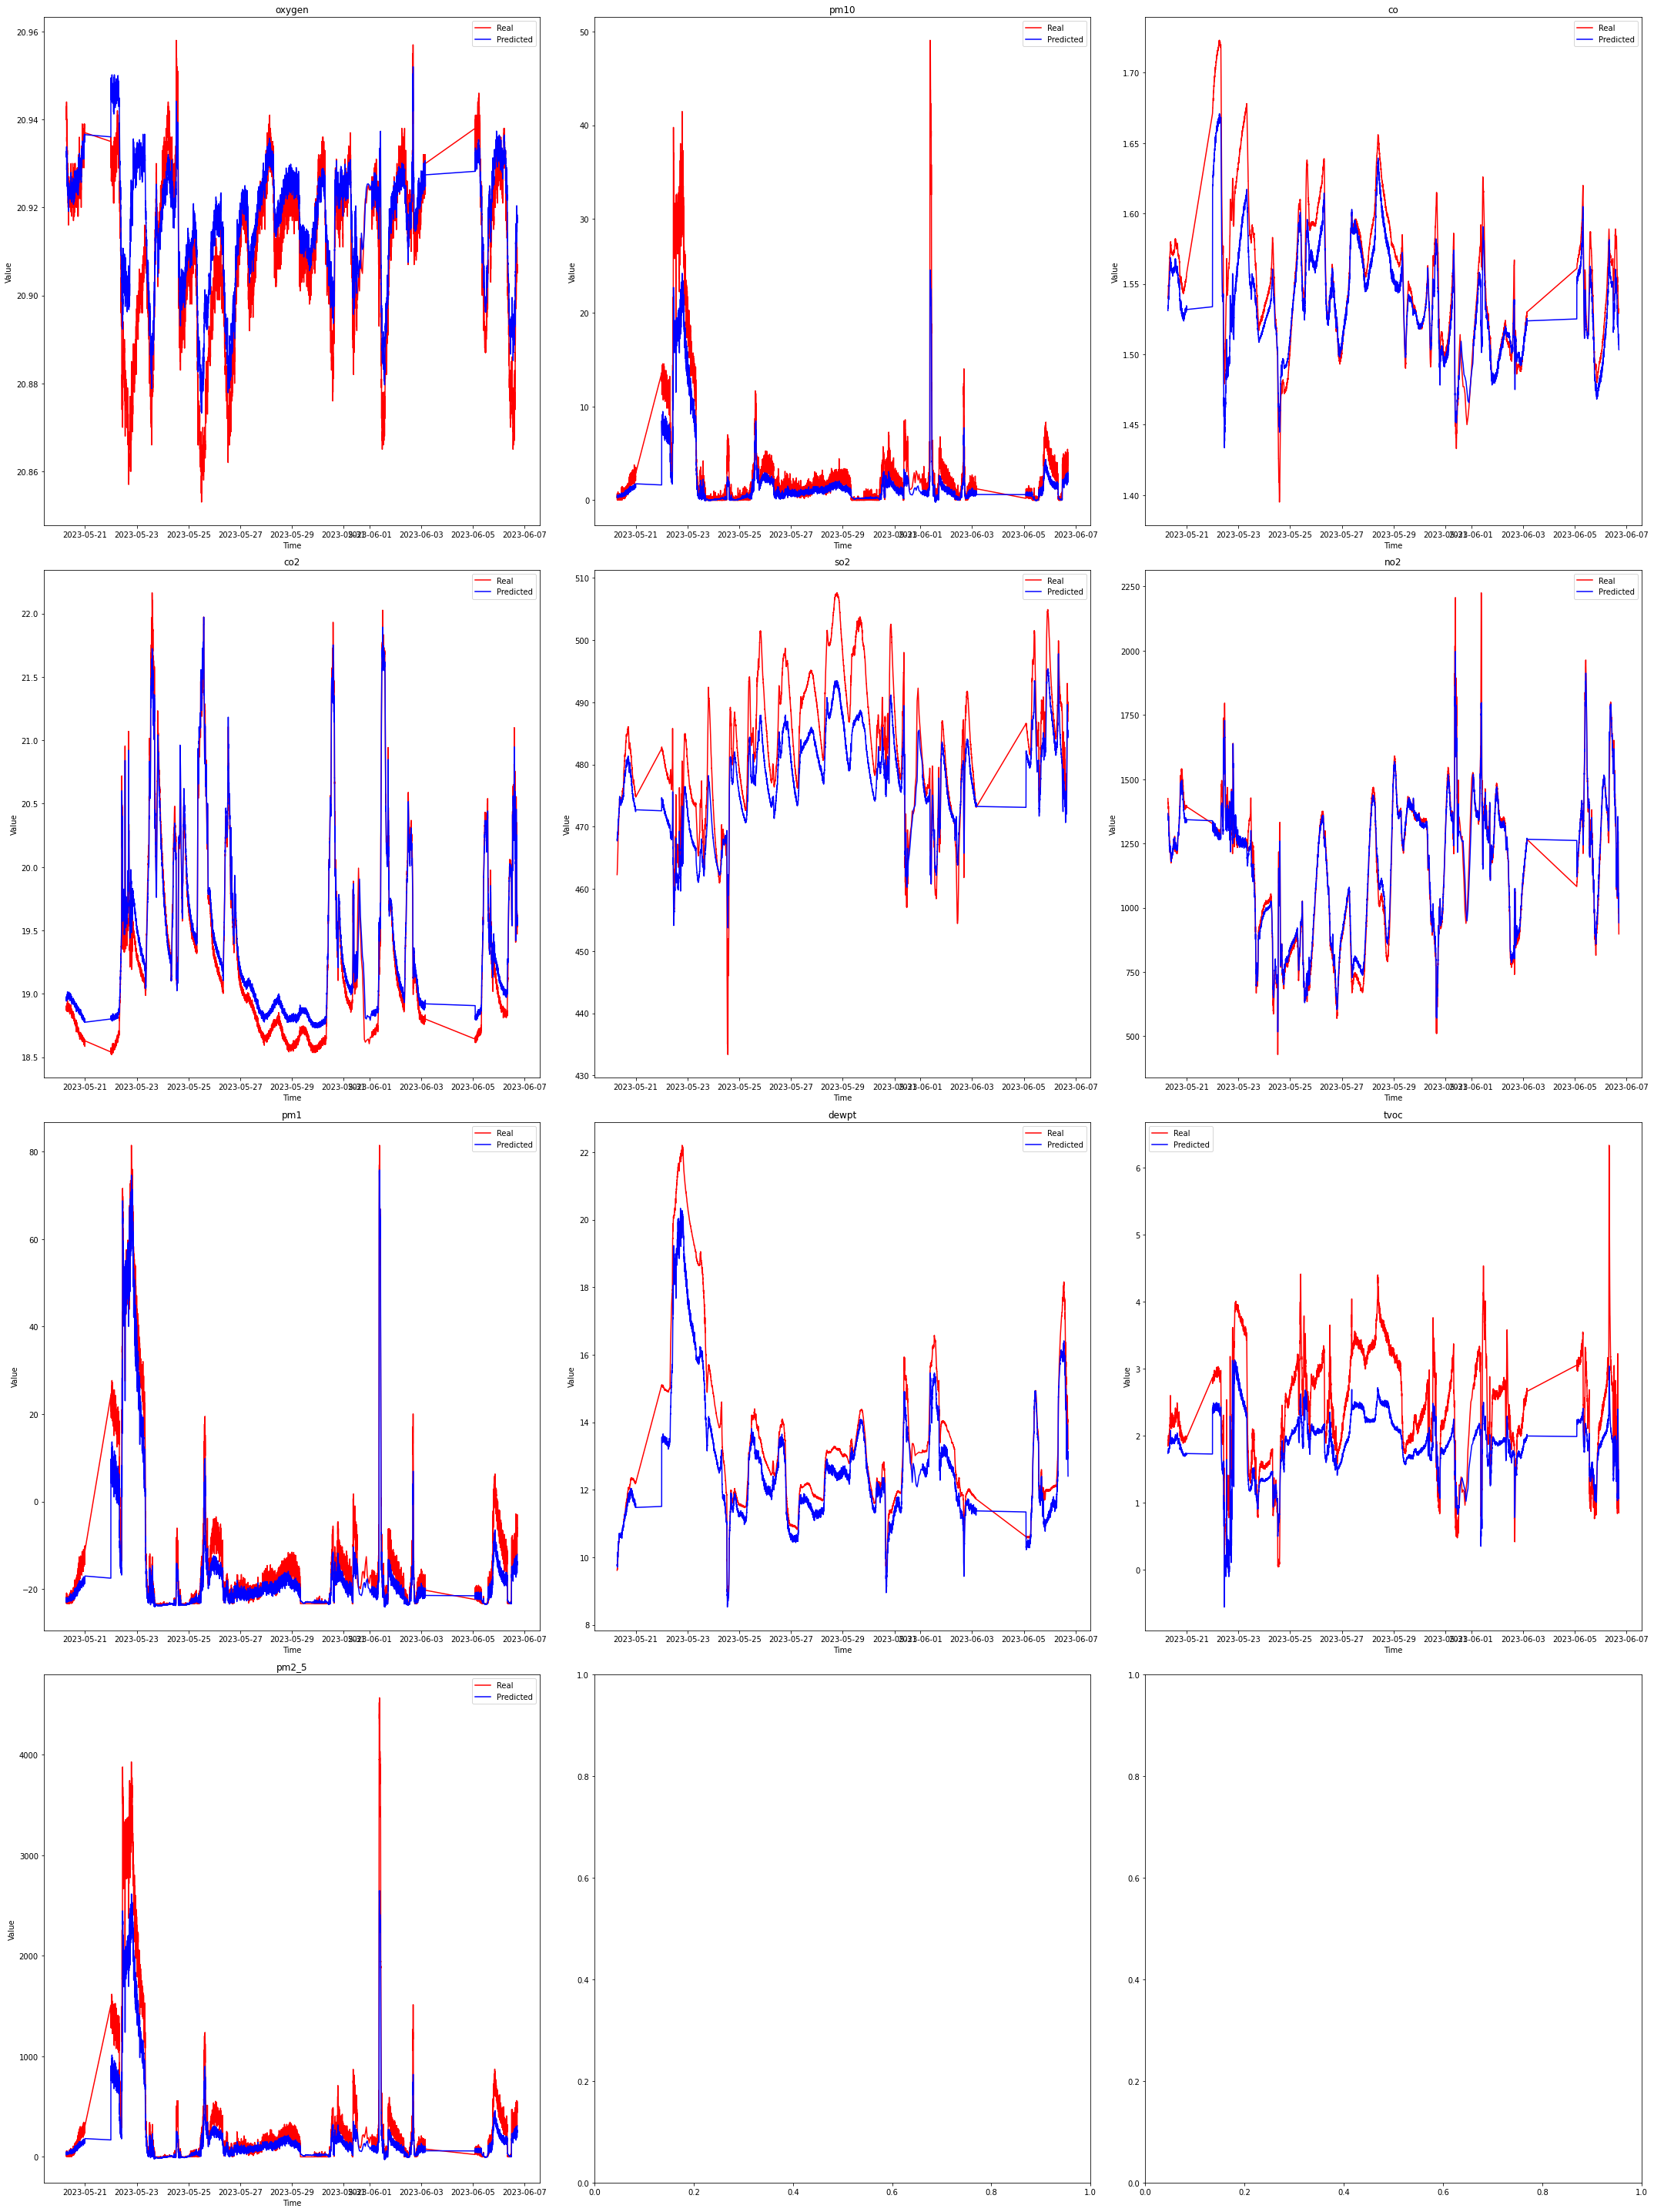

In [56]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
selected_columns = [i for i in range(test_X.shape[1]) if i in [3, 10, 11]]

inv_yhat = np.concatenate((yhat, test_X[:, selected_columns]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
# inv_yhat = inv_yhat[:, selected_columns]

test_y = test_y.reshape((len(test_y), 10))
inv_y = np.concatenate((test_y, test_X[:, selected_columns]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
# inv_y = inv_y[:, selected_columns]

dates = dates[-9997:]
fig, axs = plt.subplots(4, 3, figsize=(30, 40))
feature_indices = {
    'oxygen': 0, 'pm10': 1, 'co': 2, 'co2': 3, 'so2': 4,
    'no2': 5, 'pm1': 6, 'dewpt': 7, 'tvoc': 8, 'pm2_5': 9
}
for i, (feature, index) in enumerate(feature_indices.items()):
    row = i // 3
    col = i % 3

    axs[row, col].plot(dates,inv_y[:, index], color='red', label='Real')
    axs[row, col].plot(dates,inv_yhat[:, index], color='blue', label='Predicted')
    axs[row, col].set_title(feature)
    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel('Value')
    axs[row, col].legend()

plt.tight_layout()
plt.show()

# rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
# print('Test RMSE: %.3f' % rmse)

In [57]:
selected_columns2 = [i for i in range(test_X.shape[1]) if i not in [3, 10, 11]]
inv_yhat = inv_yhat[:, selected_columns2]
inv_y = inv_y[:, selected_columns2]
print(inv_y.shape, inv_yhat.shape)
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

(9997, 10) (9997, 10)
Test RMSE: 89.517


anticiper

In [58]:
n_seconds = 7
n_features = 13

reframed = series_to_supervised(scaled, n_seconds, 1)

In [59]:
reframed.drop(reframed.columns[[-2,-3,-10]], axis=1, inplace=True)
reframed.head(10)

,var1(t-7),var2(t-7),var3(t-7),var4(t-7),var5(t-7),var6(t-7),var7(t-7),var8(t-7),var9(t-7),var10(t-7),...,var1(t),var2(t),var3(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t),var13(t)
7,0.003632,0.000143,0.504839,0.403439,0.255490,0.075925,0.484318,0.0,0.532229,0.0,...,0.003632,0.000020,0.503226,0.221756,0.075922,0.498707,0.0,0.529062,0.0,0.0
8,0.000000,0.000020,0.503226,0.403120,0.245141,0.075925,0.487801,0.0,0.530976,0.0,...,0.010910,0.000000,0.501613,0.212793,0.075920,0.498278,0.0,0.528073,0.0,0.0
9,0.000000,0.000000,0.503226,0.403280,0.242316,0.075926,0.489156,0.0,0.530646,0.0,...,0.003632,0.000000,0.500000,0.207276,0.075919,0.497486,0.0,0.527347,0.0,0.0
10,0.003632,0.004342,0.503226,0.402961,0.236485,0.075925,0.491561,0.0,0.530514,0.0,...,0.000000,0.000000,0.498387,0.209201,0.075918,0.504289,0.0,0.526753,0.0,0.0
11,0.000000,0.003099,0.504839,0.403439,0.245246,0.075925,0.494003,0.0,0.530712,0.0,...,0.025452,0.000000,0.498387,0.196038,0.075917,0.505005,0.0,0.526094,0.0,0.0
12,0.014542,0.002120,0.504839,0.402643,0.242031,0.075925,0.497037,0.0,0.530382,0.0,...,0.014542,0.000000,0.498387,0.199882,0.075917,0.506226,0.0,0.525500,0.0,0.0
13,0.014542,0.000245,0.506452,0.401051,0.231752,0.075924,0.497285,0.0,0.529788,0.0,...,0.007271,0.000000,0.498387,0.207340,0.075915,0.510300,0.0,0.526687,0.0,0.0
14,0.003632,0.000020,0.503226,0.398981,0.221756,0.075922,0.498707,0.0,0.529062,0.0,...,0.036362,0.000000,0.498387,0.205613,0.075914,0.515023,0.0,0.527479,0.0,0.0
15,0.010910,0.000000,0.501613,0.396115,0.212793,0.075920,0.498278,0.0,0.528073,0.0,...,0.029091,0.000000,0.500000,0.199396,0.075917,0.520929,0.0,0.527743,0.0,0.0
16,0.003632,0.000000,0.500000,0.394682,0.207276,0.075919,0.497486,0.0,0.527347,0.0,...,0.029091,0.003629,0.498387,0.196817,0.075918,0.524297,0.0,0.527413,0.0,0.0


In [60]:
values = reframed.values
num_rows = data.shape[0]
train_samples = int(num_rows // 1.25)

train = values[:train_samples, :]
test = values[train_samples:, :]
n_obs = n_seconds * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features+3:]
test_X, test_y = test[:, :n_obs], test[:, -n_features+3:]
print( train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(39992, 91) (39992, 10) (9991, 91) (9991, 10)


In [61]:
train_X = train_X.reshape((train_X.shape[0], n_seconds, n_features))
test_X = test_X.reshape((test_X.shape[0], n_seconds, n_features))

print(test_X.shape,train_X.shape)

(9991, 7, 13) (39992, 7, 13)


In [62]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.5))
model.add(Dense(10))
model.compile(loss='mae', optimizer='adam')
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 50)                12800     
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                510       
Total params: 13,310
Trainable params: 13,310
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/300
556/556 - 3s - loss: 0.0898 - val_loss: 0.0737
Epoch 2/300
556/556 - 2s - loss: 0.0514 - val_loss: 0.0733
Epoch 3/300
556/556 - 2s - loss: 0.0417 - val_loss: 0.0661
Epoch 4/300
556/556 - 2s - loss: 0.0375 - val_loss: 0.0617
Epoch 5/300
556/556 - 2s - loss: 0.0350 - val_loss: 0.0574
Epoch 6/300
556/556 - 2s - loss: 0.0328 - val_loss: 0.0557
Epoch 7/300
556/556 - 2s - loss: 0.0316 - val_loss: 0.0551
Epoch 8/300
556/556 - 2s - loss: 0.0305 - val_loss: 0.0530
Epoch 9/300
556/556 - 2s - loss: 0.0300 - val_loss: 0.0523
Epoch 10/300
556/556 - 2s - loss: 0.0295 - val_loss: 0.0508
Epoch 11/300
556/556 - 2s - loss: 0.0292 - val_loss: 0.0494
Epoch 12/300
556/556 - 2s - loss: 0.0287 - val_loss: 0.0493
Epoch 13/300
556/556 - 2s - loss: 0.0282 - val_loss: 0.0486
Epoch 14/300
556/556 - 2s - loss: 0.0277 - val_loss: 0.0485
Epoch 15/300
556/556 - 2s - loss: 0.0275 - val_loss: 0.0476
Epoch 16/300
556/556 - 2s - loss: 0.0271 - val_loss: 0.0452
Epoch 17/300
556/556 - 2s - loss: 0.0268 - val_lo

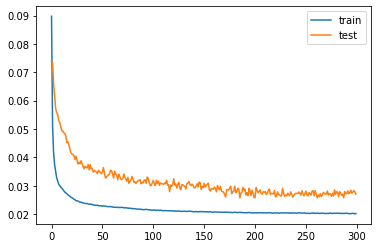

In [63]:
history = model.fit(train_X, train_y, epochs=300, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

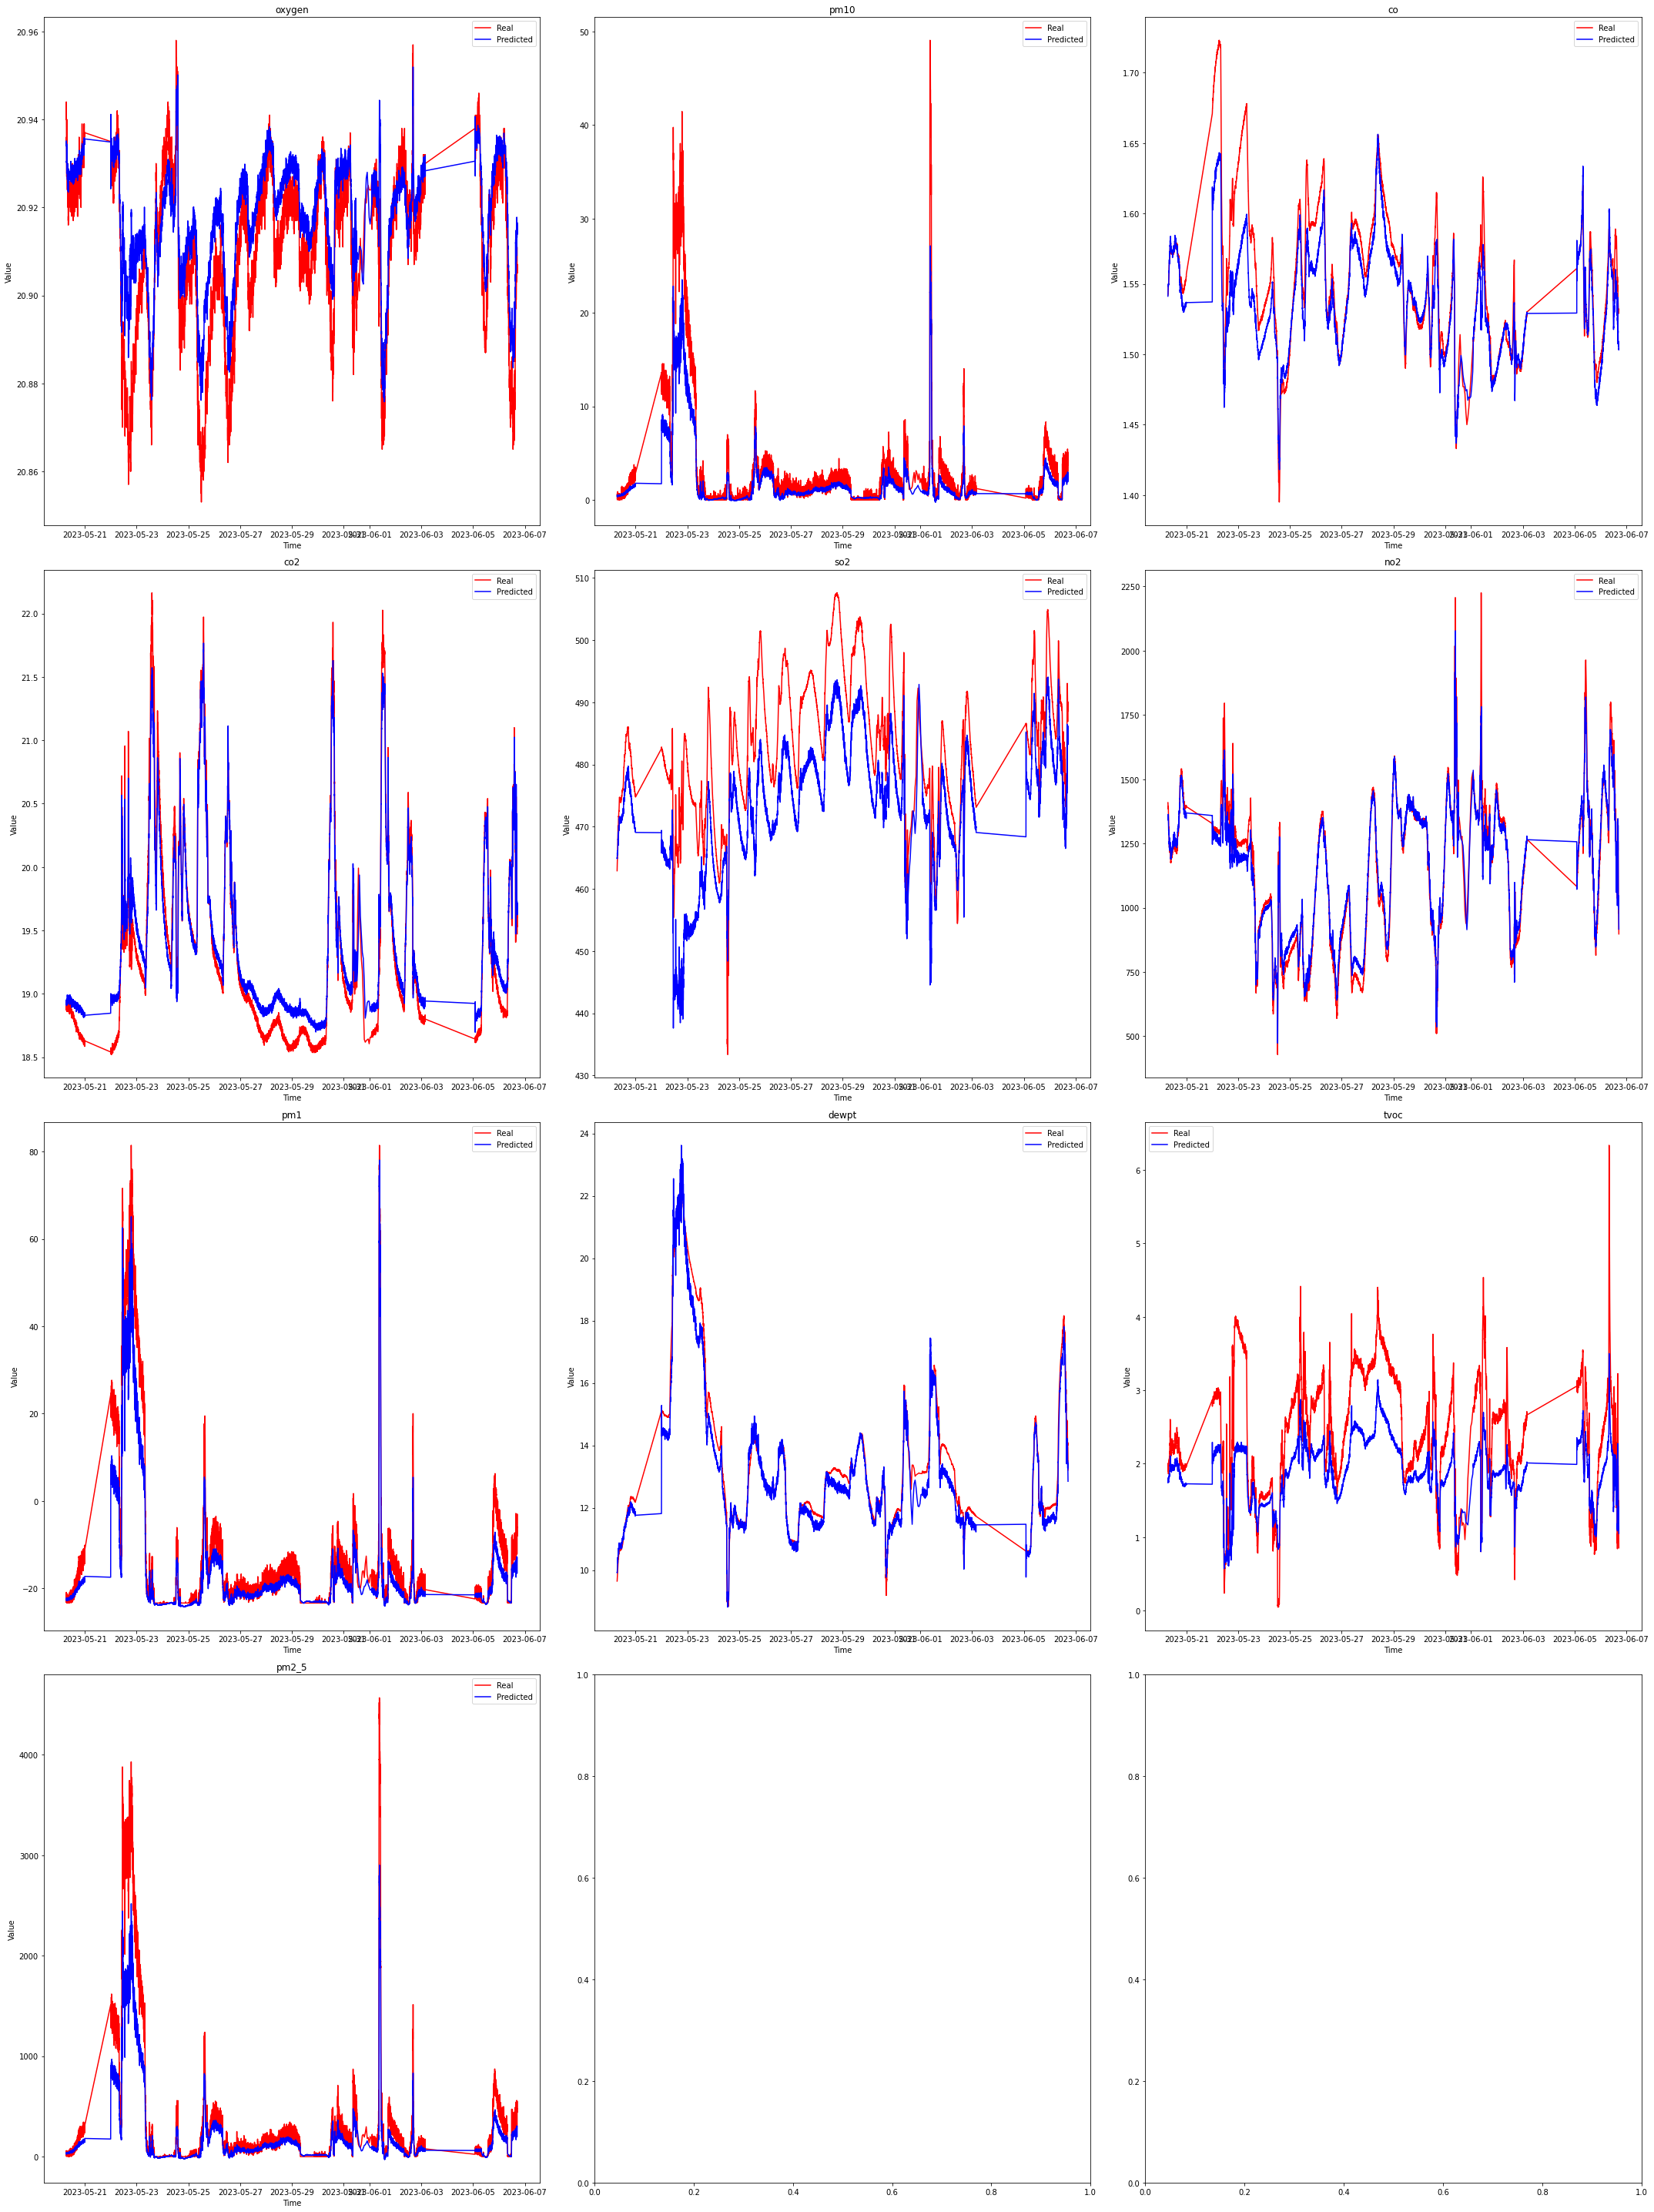

In [64]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_seconds*n_features))

selected_columns = [i for i in range(test_X.shape[1]) if i in [3, 10, 11]]

inv_yhat = np.concatenate((yhat, test_X[:, selected_columns]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
# inv_yhat = inv_yhat[:, selected_columns]

test_y = test_y.reshape((len(test_y), 10))
inv_y = np.concatenate((test_y, test_X[:, selected_columns]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
# inv_y = inv_y[:, selected_columns]
dates = dates[-9991:]
fig, axs = plt.subplots(4, 3, figsize=(30, 40))
feature_indices = {
    'oxygen': 0, 'pm10': 1, 'co': 2, 'co2': 3, 'so2': 4,
    'no2': 5, 'pm1': 6, 'dewpt': 7, 'tvoc': 8, 'pm2_5': 9
}
for i, (feature, index) in enumerate(feature_indices.items()):
    row = i // 3
    col = i % 3

    axs[row, col].plot(dates,inv_y[:, index], color='red', label='Real')
    axs[row, col].plot(dates,inv_yhat[:, index], color='blue', label='Predicted')
    axs[row, col].set_title(feature)
    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel('Value')
    axs[row, col].legend()

plt.tight_layout()
plt.show()
# rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
# print('Test RMSE: %.3f' % rmse)

In [65]:
selected_columns2 = [i for i in range(n_features) if i not in [3, 10, 11]]
inv_yhat = inv_yhat[:, selected_columns2]
inv_y = inv_y[:, selected_columns2]
print(inv_y.shape, inv_yhat.shape)
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

(9991, 10) (9991, 10)
Test RMSE: 103.569
